In [1]:
import bioalerts
from bioalerts import LoadMolecules, Alerts, FPCalculator
import sys

In [2]:
import numpy as np 
import matplotlib.pyplot as plt

from rdkit.Chem.Draw import IPythonConsole 
from rdkit.Chem import PandasTools 

import pandas as pd 

from sklearn.neighbors import KNeighborsRegressor #knn
from sklearn.ensemble import RandomForestRegressor #RF
from sklearn.svm import SVR #SVR

from sklearn.model_selection import train_test_split, cross_val_score 
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import RepeatedKFold

In [7]:
smiles_path = "./tutorial/datasets/androgen.smi"
bio_path = './tutorial/datasets/androgen.bio.txt'

wdir =  'C:/jupyter_devel/kist-europe/QSAR/AOP_data/'
csv = 'cleandata_androgen_ec50_check-maccs-remcols-stdval.csv'
result_wdir = 'C:/jupyter_devel/kist-europe/QSAR/AOP_data/model_result/'

In [8]:
df = pd.read_csv(wdir+csv)

In [9]:
y = df['Standard Value']
x = df.drop(['Molecule','Standard Value'],axis=1)

## A. Data Visualization

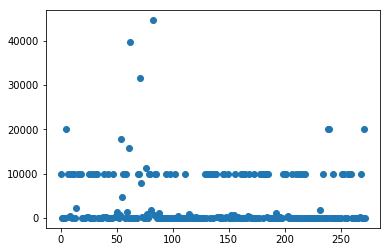

In [10]:
x_ = range(len(x))
plt.scatter(x_,y)
#plt.ylim(0,50000)

#### PIC transformation Formula ####
# PIC = 9 - np.log10(actual activity)
# actual activity = np,power(10,9-PIC)

## B. calculate significant substructure feature

In [ ]:
molecules = bioalerts.LoadMolecules.LoadMolecules(smiles_path,name_field=None)
molecules.ReadMolecules()

In [ ]:
cox_bio = np.genfromtxt(bio_path,skip_header=0) 
cox_bio.shape
arr = np.arange(0,len(cox_bio))
mask = np.ones(arr.shape,dtype=bool)
mask[molecules.molserr]=0
cox_bio = cox_bio[mask]
print len(cox_bio)
print len(molecules.mols)

In [ ]:
dataset_info = bioalerts.LoadMolecules.GetDataSetInfo(name_field=None)
dataset_info.extract_substructure_information(radii=[2,3,4,5,6],mols=molecules.mols)

In [ ]:
Alerts_continuous_high_activity = bioalerts.Alerts.CalculatePvaluesContinuous(radii_ext=[2,3,4,5,6])

In [ ]:
def calculate_bioactivity_threshold(bio,threshold):
    # a pIC50 is smaller, higher activity 
    
    sorted_bio = sorted(bio)
    threshold_bio_value = sorted_bio[int(len(sorted_bio)*threshold)]
    
    print("activity ratio is {}".format(1-threshold))
    print("threshold value is {}".format(threshold_bio_value))
    print("actual bioactivity value is {}".format(np.power(10,9 - threshold_bio_value)))
    return threshold_bio_value

In [ ]:
threshold_= 0.33
threshold_bio_value = calculate_bioactivity_threshold(cox_bio,threshold_)

threshold_nb_substructures = 10
threshold_ratio = 0.3
threshold_high_act_nb_substructures = 5 #5
threshold_high_act_ratio = 0.29 #0.5                                                                  

# maybe no necessary to change
threshold_pvalue = 0.05 

In [ ]:
significant_substructure = {}
significant_substructure = Alerts_continuous_high_activity.get_significant_substructure_with_high_bioactivity(
mols = molecules.mols,
     substructure_dictionary = dataset_info.substructure_dictionary,
     bioactivities = cox_bio,
     mols_ids = molecules.mols_ids[:],
     threshold_nb_substructures = threshold_nb_substructures,
     threshold_pvalue = threshold_pvalue,
     threshold_ratio=threshold_ratio,
     threshold_high_act_nb_substructures=threshold_high_act_nb_substructures,
     threshold_high_act_ratio = threshold_high_act_ratio,                                                                        
     threshold_bioactivity=threshold_bio_value)

#threshold_high_act_nb_substructure = N of molecules involved significant substructure with high activity  
#threshold_high_act_ratio = N of molecules involved significant substructure with high activity / N of molecules involved significant substructure
#threshold_bioactivity = Top 40% by total bioactivity

#return value is significant_substructure dictionary with high activity

In [ ]:
mol_id_set = set()
for k,v in significant_substructure.items():
    for mol_id in v: 
        mol_id_set.add(mol_id)

In [ ]:
print('number of total substructure : {}'.format(len(dataset_info.substructure_dictionary)))
print('number of extracted significant substructure : {}'.format(len(significant_substructure)))
print('{} out of {} have the label which represent remaining significant substructure\n'.format(len(mol_id_set),len(cox_bio)))

print ('THRESHOLD - \n\tnumber of substructures : {}\n\tp value : {}\n\tratio : {}\n\tnumber of high activity threshold : {}\n\thigh activity ratio : {}\n\thigh bioactivity threshold : {}'
       .format(threshold_nb_substructures,threshold_pvalue,threshold_ratio,threshold_high_act_nb_substructures,threshold_high_act_ratio,threshold_ ))

In [ ]:
# run the code when you repair hyperparameter
if len(significant_substructure) is not 0 :
    significant_substructure.clear()
if len(mol_id_set) is not 0 :
    mol_id_set.clear()

## C. insert feature

In [11]:
y_pic50 = 9 - np.log10(y)

In [ ]:
#insert feature into only train dataset
for iter_ in x.index:
    for i in range(8): 
        if iter_ in mol_id_set : 
            x.loc[iter_,'significant_feature_{}'.format(i)] = 1.0
        else :
            x.loc[iter_,'significant_feature_{}'.format(i)] = 0.0

## D. model train

In [12]:
test_size = 0.1 
x_train, x_test, y_train, y_test = train_test_split(x,y_pic50,test_size = test_size, shuffle = True)

In [13]:
x_test_idx = []
for row in x_test.index:
    x_test_idx.append(row)

### D.1.1 KNN hyperparameter search 

In [14]:
from sklearn.model_selection import GridSearchCV 

neigh = KNeighborsRegressor()
param_grid = {'n_neighbors':[4,5,6,7,8],
              'algorithm':['auto','ball_tree','brute'],
              'metric':['jaccard','matching','dice'],
             'weights':['uniform','distance']} 
KNN_search = GridSearchCV(neigh,param_grid,cv=5)
KNN_search.fit(x_train,y_train)
print("Bset Parameters set found on GridSearch CV :\n")
print(KNN_search.best_params_)

C:\Users\chon0\Anaconda3\envs\py27\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to bool by check_pairwise_arrays.
  warnings.warn(msg, DataConversionWarning)


Bset Parameters set found on GridSearch CV :

{'n_neighbors': 5, 'metric': 'matching', 'weights': 'distance', 'algorithm': 'brute'}


In [15]:
print("Grid scores on GridSearchCV :\n")

means = KNN_search.cv_results_['mean_test_score']
stds = KNN_search.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, KNN_search.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))

Grid scores on GridSearchCV :

0.281 (+/-0.231) for {'n_neighbors': 4, 'metric': 'jaccard', 'weights': 'uniform', 'algorithm': 'auto'}
0.300 (+/-0.208) for {'n_neighbors': 4, 'metric': 'jaccard', 'weights': 'distance', 'algorithm': 'auto'}
0.283 (+/-0.193) for {'n_neighbors': 5, 'metric': 'jaccard', 'weights': 'uniform', 'algorithm': 'auto'}
0.312 (+/-0.175) for {'n_neighbors': 5, 'metric': 'jaccard', 'weights': 'distance', 'algorithm': 'auto'}
0.282 (+/-0.155) for {'n_neighbors': 6, 'metric': 'jaccard', 'weights': 'uniform', 'algorithm': 'auto'}
0.316 (+/-0.153) for {'n_neighbors': 6, 'metric': 'jaccard', 'weights': 'distance', 'algorithm': 'auto'}
0.269 (+/-0.160) for {'n_neighbors': 7, 'metric': 'jaccard', 'weights': 'uniform', 'algorithm': 'auto'}
0.310 (+/-0.141) for {'n_neighbors': 7, 'metric': 'jaccard', 'weights': 'distance', 'algorithm': 'auto'}
0.270 (+/-0.146) for {'n_neighbors': 8, 'metric': 'jaccard', 'weights': 'uniform', 'algorithm': 'auto'}
0.311 (+/-0.135) for {'n_neig

In [ ]:
knn_search_pred = KNN_search.predict(x_test)

# test rseult 
print("\ntest RMSE : {}".format(round(np.sqrt(mean_squared_error(y_test,knn_search_pred)),4)) )

In [16]:
KNN_search.best_params_

{'algorithm': 'brute',
 'metric': 'matching',
 'n_neighbors': 5,
 'weights': 'distance'}

### D.1.2 KNN model train

In [37]:
#fold setting
kf = RepeatedKFold(n_splits = 5,n_repeats=10)
kf.get_n_splits(x_train)
#kf
#>>> KFold(n_splits=5, random_state=None, shuffle=False)

#for numbering k folds
k=0
cv_rmse = []
cv_rmse_mean = []
tmp = []

#DataFrame generate
y_pic_pred_result = pd.DataFrame()
y_pic_pred_result['idx'] = pd.Series([i for i in range(len(y))])


##################    using hyperparameter tuning model    ##################    
#model generate
neigh = KNeighborsRegressor(n_neighbors = 5, metric='matching',weights='distance',algorithm='brute')
#KNN without sig, for androgen {'n_neighbors': 5, 'metric': 'matching', 'weights': 'distance', 'algorithm': 'brute'}
##################    using hyperparameter tuning model    ##################


#cross-val training
for train_idx, test_idx in kf.split(x_train):
    #print("iteration num : {}".format(k))
    #print("train : ", train_idx, "\ntest : ", test_idx)
    x_cv_train , x_cv_test = x_train.iloc[train_idx], x_train.iloc[test_idx]
    y_cv_train , y_cv_test = y_train.iloc[train_idx], y_train.iloc[test_idx]
    
    neigh.fit(x_cv_train,y_cv_train)
    
    y_cv_testidx = test_idx
    y_cv_pred = neigh.predict(x_cv_test)
    cv_rmse.append(round(np.sqrt(mean_squared_error(y_cv_test,y_cv_pred)),4))
    cv_rmse_mean.append(round(np.sqrt(mean_squared_error(y_cv_test,y_cv_pred)),4))
    
    y_pic_pred_result['y_cv_testidx_{}'.format(k)] = pd.Series()
    y_pic_pred_result['y_cv_pred_{}'.format(k)] = pd.Series()
    
    for j in range(len(y_cv_testidx)):
        y_pic_pred_result.loc[y_cv_testidx[j],'y_cv_testidx_{}'.format(k)] = y_cv_testidx[j]
        y_pic_pred_result.loc[y_cv_testidx[j],'y_cv_pred_{}'.format(k)] = y_cv_pred[j]            
    
    #y_pic_pred_result['y_cv_testidx_{}'.format(i)] = pd.Series(y_cv_testidx)
    #y_pic_pred_result['y_cv_pred_{}'.format(i)] = pd.Series(y_cv_pred)
    k += 1 
    
    if k % 5 == 0 : 
        tmp.append(np.mean(cv_rmse_mean))
        print(cv_rmse_mean) # per fold rmse value in one cv 
        print("mean : ",np.mean(cv_rmse_mean)) # RMSE mean value per iteration of cv  
        del cv_rmse_mean[:]
        

print("total fold mean : ", round(np.mean(cv_rmse),4)) # mean of 50 cv rmse (1회 iter돌 때의 모든 rmse의 평균 (50회의 평균)) 
print("total cv mean : ",round(np.mean(tmp),4)) # mean of cv's mean of 1 iter (각 cv rmse 평균의 평균) # we need var of this value 

#model retrain with all train data  
neigh.fit(x_train,y_train) # > model train
y_pic_test_pred = neigh.predict(x_test) # > model predidction

# 
y_pic_test_pred_df = pd.DataFrame(columns=['y_pic_test_idx','y_pic_test_pred'])
for j in range(len(x_test_idx)):
        y_pic_test_pred_df.loc[x_test_idx[j],'y_pic_test_idx'] = x_test_idx[j]
        y_pic_test_pred_df.loc[x_test_idx[j],'y_pic_test_pred'] = y_pic_test_pred[j]
#y_pic_test_pred_df = pd.DataFrame(y_pic_test_pred,columns=['y_pic_test_pred'])
y_pic_pred_result = pd.concat([y_pic_pred_result, y_pic_test_pred_df], axis=1, ignore_index=False)

#save csv 
#y_pic_pred_result.to_csv(result_wdir+'5-alpha-reductase_dltnan_y_pic_pred_result+with_significant_feature.csv',index=True)


iteration num : 0
iteration num : 1
iteration num : 2
iteration num : 3
iteration num : 4
[1.0504, 1.3656, 1.0345, 1.2952, 1.2829]
('mean : ', 1.20572)
iteration num : 5
iteration num : 6
iteration num : 7
iteration num : 8
iteration num : 9
[1.3984, 1.0851, 1.1218, 1.4333, 1.244]
('mean : ', 1.25652)
iteration num : 10
iteration num : 11
iteration num : 12
iteration num : 13
iteration num : 14
[1.101, 1.2689, 1.4575, 1.3115, 1.1448]
('mean : ', 1.25674)
iteration num : 15
iteration num : 16
iteration num : 17
iteration num : 18
iteration num : 19
[1.2328, 1.2237, 1.2711, 1.3236, 1.297]
('mean : ', 1.2696399999999999)
iteration num : 20
iteration num : 21
iteration num : 22
iteration num : 23
iteration num : 24
[1.2214, 1.219, 1.2938, 1.0986, 1.252]
('mean : ', 1.21696)
iteration num : 25
iteration num : 26
iteration num : 27
iteration num : 28
iteration num : 29
[1.2236, 1.2892, 1.3254, 1.0816, 1.1107]
('mean : ', 1.2061)
iteration num : 30
iteration num : 31
iteration num : 32
iterat

### D.1.3 KNN model results

In [38]:
#RESULT
print("train data size : {} ({}%)\n".format(len(x_train),round((len(x_train)/len(x)),2)), "test data size : {} ({}%)\n".format(len(x_test),round((len(x_test)/len(x)),2)))
print("each CV RMSE average : \n{} \nVARIANCE of RMSE of every folds : {}\n".format(tmp,round(np.var(cv_rmse),4)))

print("total 50 folds RMSE mean : ", round(np.mean(cv_rmse),4)) # mean of 50 cv rmse (1회 iter돌 때의 모든 rmse의 평균 (50회의 평균)) 
print("total 10 CVs RMSE mean : ",round(np.mean(tmp),4)) # mean of cv's mean of 1 iter (각 cv rmse 평균의 평균) # we need var of this value 

# test rseult 
print("\ntest RMSE : {}".format(round(np.sqrt(mean_squared_error(y_test,y_pic_test_pred)),4)) )

('train data size : 245 (0.0%)\n', 'test data size : 28 (0.0%)\n')
each CV RMSE average : 
[1.20572, 1.25652, 1.25674, 1.2696399999999999, 1.21696, 1.2061, 1.2365400000000002, 1.2889599999999999, 1.246, 1.2221600000000001] 
VARIANCE of RMSE of every folds : 0.013

('total 50 folds RMSE mean : ', 1.2405)
('total 10 CVs RMSE mean : ', 1.2405)

test RMSE : 0.9768


### D.2.1 RF hyperparameter tuning

In [42]:
from sklearn.model_selection import GridSearchCV
RF = RandomForestRegressor()
RF_param_grid = {'n_estimators':[40,60,80,100],
              'max_depth':[30,40,50,None],
                'min_samples_split':[2,3,4,5,6]} 
RF_search = GridSearchCV(RF,RF_param_grid,cv=5)
RF_search.fit(x_train,y_train)
print("Bset Parameters set found on GridSearch CV :\n")
print(RF_search.best_params_)

Bset Parameters set found on GridSearch CV :

{'min_samples_split': 5, 'n_estimators': 40, 'max_depth': 40}


In [43]:
print("Grid scores on GridSearchCV :\n")

means = RF_search.cv_results_['mean_test_score']
stds = RF_search.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, RF_search.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))

Grid scores on GridSearchCV :

0.454 (+/-0.234) for {'min_samples_split': 2, 'n_estimators': 40, 'max_depth': 30}
0.439 (+/-0.227) for {'min_samples_split': 2, 'n_estimators': 60, 'max_depth': 30}
0.432 (+/-0.225) for {'min_samples_split': 2, 'n_estimators': 80, 'max_depth': 30}
0.456 (+/-0.242) for {'min_samples_split': 2, 'n_estimators': 100, 'max_depth': 30}
0.450 (+/-0.223) for {'min_samples_split': 3, 'n_estimators': 40, 'max_depth': 30}
0.432 (+/-0.246) for {'min_samples_split': 3, 'n_estimators': 60, 'max_depth': 30}
0.439 (+/-0.242) for {'min_samples_split': 3, 'n_estimators': 80, 'max_depth': 30}
0.439 (+/-0.225) for {'min_samples_split': 3, 'n_estimators': 100, 'max_depth': 30}
0.455 (+/-0.229) for {'min_samples_split': 4, 'n_estimators': 40, 'max_depth': 30}
0.438 (+/-0.272) for {'min_samples_split': 4, 'n_estimators': 60, 'max_depth': 30}
0.440 (+/-0.214) for {'min_samples_split': 4, 'n_estimators': 80, 'max_depth': 30}
0.430 (+/-0.215) for {'min_samples_split': 4, 'n_estim

### D.2.2 RF model train

In [40]:
test_size = 0.1 
x_train, x_test, y_train, y_test = train_test_split(x,y_pic50,test_size = test_size, shuffle = True)

In [41]:
x_test_idx = []
for row in x_test.index:
    x_test_idx.append(row)

In [44]:
#fold setting
kf = RepeatedKFold(n_splits = 5,n_repeats=10)
kf.get_n_splits(x_train)
#kf
#>>> KFold(n_splits=5, random_state=None, shuffle=False)

#for numbering k folds
k=0
cv_rmse = []
cv_rmse_mean = []
tmp = []

#DataFrame generate
y_pic_pred_result = pd.DataFrame()
y_pic_pred_result['idx'] = pd.Series([i for i in range(len(y))])

#model generate
##################    using hyperparameter tuning model    ##################    
RF = RandomForestRegressor(n_estimators= 40,min_samples_split=5,max_depth=40)

#RF without sig, for androgen {'min_samples_split': 5, 'n_estimators': 40, 'max_depth': 40}
#RF with sig, for androgen 

#RF without sig, for aromatase {'min_samples_split': 3, 'n_estimators': 60, 'max_depth': 30}
#RF with sig , for aromatase {'min_samples_split': 2, 'n_estimators': 40, 'max_depth': None}
#
##################    using hyperparameter tuning model    ##################

#cross-val training
for train_idx, test_idx in kf.split(x_train):
    #print("iteration num : {}".format(k))
    #print("train : ", train_idx, "\ntest : ", test_idx)
    x_cv_train , x_cv_test = x_train.iloc[train_idx], x_train.iloc[test_idx]
    y_cv_train , y_cv_test = y_train.iloc[train_idx], y_train.iloc[test_idx]
    
    RF.fit(x_cv_train,y_cv_train)
    
    y_cv_testidx = test_idx
    y_cv_pred = RF.predict(x_cv_test)
    cv_rmse.append(round(np.sqrt(mean_squared_error(y_cv_test,y_cv_pred)),4))
    cv_rmse_mean.append(round(np.sqrt(mean_squared_error(y_cv_test,y_cv_pred)),4))
    
    y_pic_pred_result['y_cv_testidx_{}'.format(k)] = pd.Series()
    y_pic_pred_result['y_cv_pred_{}'.format(k)] = pd.Series()
    
    for j in range(len(y_cv_testidx)):
        y_pic_pred_result.loc[y_cv_testidx[j],'y_cv_testidx_{}'.format(k)] = y_cv_testidx[j]
        y_pic_pred_result.loc[y_cv_testidx[j],'y_cv_pred_{}'.format(k)] = y_cv_pred[j]
        
    
    
    #y_pic_pred_result['y_cv_testidx_{}'.format(i)] = pd.Series(y_cv_testidx)
    #y_pic_pred_result['y_cv_pred_{}'.format(i)] = pd.Series(y_cv_pred)
    k += 1 
    
    if k % 5 == 0 : 
        tmp.append(np.mean(cv_rmse_mean))
        print(cv_rmse_mean) # per fold rmse value in one cv 
        print("mean : ",np.mean(cv_rmse_mean)) # RMSE mean value per iteration of cv  
        del cv_rmse_mean[:]
        

print("total fold mean : ", round(np.mean(cv_rmse),4)) # mean of 50 cv rmse (1회 iter돌 때의 모든 rmse의 평균 (50회의 평균)) 
print("total cv mean : ",round(np.mean(tmp),4)) # mean of cv's mean of 1 iter (각 cv rmse 평균의 평균) # we need var of this value 

#model retrain with all train data  
RF.fit(x_train,y_train) # > model train
y_pic_test_pred = RF.predict(x_test) # > model predidction

# 
y_pic_test_pred_df = pd.DataFrame(columns=['y_pic_test_idx','y_pic_test_pred'])
for j in range(len(x_test_idx)):
        y_pic_test_pred_df.loc[x_test_idx[j],'y_pic_test_idx'] = x_test_idx[j]
        y_pic_test_pred_df.loc[x_test_idx[j],'y_pic_test_pred'] = y_pic_test_pred[j]
#y_pic_test_pred_df = pd.DataFrame(y_pic_test_pred,columns=['y_pic_test_pred'])
y_pic_pred_result = pd.concat([y_pic_pred_result, y_pic_test_pred_df], axis=1, ignore_index=False)

#save csv 
#y_pic_pred_result.to_csv(result_wdir+'5-alpha-reductase_dltnan_y_pic_pred_result+with_significant_feature.csv',index=True)


iteration num : 0
iteration num : 1
iteration num : 2
iteration num : 3
iteration num : 4
[1.312, 1.1546, 1.1239, 1.058, 1.3898]
('mean : ', 1.2076600000000002)
iteration num : 5
iteration num : 6
iteration num : 7
iteration num : 8
iteration num : 9
[1.2195, 1.2148, 1.3784, 1.281, 0.9819]
('mean : ', 1.21512)
iteration num : 10
iteration num : 11
iteration num : 12
iteration num : 13
iteration num : 14
[1.0851, 1.1724, 1.4223, 1.1779, 1.1513]
('mean : ', 1.2018)
iteration num : 15
iteration num : 16
iteration num : 17
iteration num : 18
iteration num : 19
[1.1084, 1.145, 1.0885, 1.3173, 1.1422]
('mean : ', 1.16028)
iteration num : 20
iteration num : 21
iteration num : 22
iteration num : 23
iteration num : 24
[1.2977, 1.0731, 1.3039, 1.2361, 1.1727]
('mean : ', 1.2167)
iteration num : 25
iteration num : 26
iteration num : 27
iteration num : 28
iteration num : 29
[1.3093, 1.2805, 1.2183, 1.2133, 1.0485]
('mean : ', 1.2139799999999998)
iteration num : 30
iteration num : 31
iteration num 

### D.2.3 RF model results

In [45]:
#RESULT
print("train data size : {} ({}%)\n".format(len(x_train),round((len(x_train)/len(x)),2)), "test data size : {} ({}%)\n".format(len(x_test),round((len(x_test)/len(x)),2)))
print("each CV RMSE average : \n{} \nVARIANCE of RMSE of every folds : {}\n".format(tmp,round(np.var(cv_rmse),4)))

print("total 50 folds RMSE mean : ", round(np.mean(cv_rmse),4)) # mean of 50 cv rmse (1회 iter돌 때의 모든 rmse의 평균 (50회의 평균)) 
print("total 10 CVs RMSE mean : ",round(np.mean(tmp),4)) # mean of cv's mean of 1 iter (각 cv rmse 평균의 평균) # we need var of this value 

# test rseult 
print("\ntest RMSE : {}".format(round(np.sqrt(mean_squared_error(y_test,y_pic_test_pred)),4)) )

('train data size : 245 (0.0%)\n', 'test data size : 28 (0.0%)\n')
each CV RMSE average : 
[1.2076600000000002, 1.21512, 1.2018, 1.16028, 1.2167, 1.2139799999999998, 1.16772, 1.1887599999999998, 1.22878, 1.1893600000000002] 
VARIANCE of RMSE of every folds : 0.011

('total 50 folds RMSE mean : ', 1.199)
('total 10 CVs RMSE mean : ', 1.199)

test RMSE : 0.8187


### D.3.1 SVR hyperparameter tuning 

In [ ]:
from sklearn.model_selection import GridSearchCV
SVR = SVR()
SVR_param_grid = {'kernel':['rbf','linear','poly']} 
SVR_search = GridSearchCV(SVR,SVR_param_grid,cv=5)
SVR_search.fit(x_train,y_train)
print("Bset Parameters set found on GridSearch CV :\n")
print(SVR_search.best_params_)

In [ ]:
print("Grid scores on GridSearchCV :\n")

means = SVR_search.cv_results_['mean_test_score']
stds = SVR_search.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, SVR_search.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))

### D.3.2 SVR model train

In [ ]:
#fold setting
kf = RepeatedKFold(n_splits = 5,n_repeats=10)
kf.get_n_splits(x_train)
#kf
#>>> KFold(n_splits=5, random_state=None, shuffle=False)

#for numbering k folds
k=0
cv_rmse = []
cv_rmse_mean = []
tmp = []

#DataFrame generate
y_pic_pred_result = pd.DataFrame()
y_pic_pred_result['idx'] = pd.Series([i for i in range(len(y))])

#model generate
##################    using hyperparameter tuning model    ##################    
SVR = SVR(kernel='rbf')
##################    using hyperparameter tuning model    ##################

#cross-val training
for train_idx, test_idx in kf.split(x_train):
    print("iteration num : {}".format(k))
    #print("train : ", train_idx, "\ntest : ", test_idx)
    x_cv_train , x_cv_test = x_train.iloc[train_idx], x_train.iloc[test_idx]
    y_cv_train , y_cv_test = y_train.iloc[train_idx], y_train.iloc[test_idx]
    
    SVR.fit(x_cv_train,y_cv_train)
    
    y_cv_testidx = test_idx
    y_cv_pred = SVR.predict(x_cv_test)
    cv_rmse.append(round(np.sqrt(mean_squared_error(y_cv_test,y_cv_pred)),4))
    cv_rmse_mean.append(round(np.sqrt(mean_squared_error(y_cv_test,y_cv_pred)),4))
    
    y_pic_pred_result['y_cv_testidx_{}'.format(k)] = pd.Series()
    y_pic_pred_result['y_cv_pred_{}'.format(k)] = pd.Series()
    
    for j in range(len(y_cv_testidx)):
        y_pic_pred_result.loc[y_cv_testidx[j],'y_cv_testidx_{}'.format(k)] = y_cv_testidx[j]
        y_pic_pred_result.loc[y_cv_testidx[j],'y_cv_pred_{}'.format(k)] = y_cv_pred[j]
        
    
    
    #y_pic_pred_result['y_cv_testidx_{}'.format(i)] = pd.Series(y_cv_testidx)
    #y_pic_pred_result['y_cv_pred_{}'.format(i)] = pd.Series(y_cv_pred)
    k += 1 
    
    if k % 5 == 0 : 
        tmp.append(np.mean(cv_rmse_mean))
        print(cv_rmse_mean) # per fold rmse value in one cv 
        print("mean : ",np.mean(cv_rmse_mean)) # RMSE mean value per iteration of cv  
        del cv_rmse_mean[:]
        

print("total fold mean : ", round(np.mean(cv_rmse),4)) # mean of 50 cv rmse (1회 iter돌 때의 모든 rmse의 평균 (50회의 평균)) 
print("total cv mean : ",round(np.mean(tmp),4)) # mean of cv's mean of 1 iter (각 cv rmse 평균의 평균) # we need var of this value 

#model retrain with all train data  
SVR.fit(x_train,y_train) # > model train
y_pic_test_pred = SVR.predict(x_test) # > model predidction

# 
y_pic_test_pred_df = pd.DataFrame(columns=['y_pic_test_idx','y_pic_test_pred'])
for j in range(len(x_test_idx)):
        y_pic_test_pred_df.loc[x_test_idx[j],'y_pic_test_idx'] = x_test_idx[j]
        y_pic_test_pred_df.loc[x_test_idx[j],'y_pic_test_pred'] = y_pic_test_pred[j]
#y_pic_test_pred_df = pd.DataFrame(y_pic_test_pred,columns=['y_pic_test_pred'])
y_pic_pred_result = pd.concat([y_pic_pred_result, y_pic_test_pred_df], axis=1, ignore_index=False)

#save csv 
#y_pic_pred_result.to_csv(result_wdir+'5-alpha-reductase_dltnan_y_pic_pred_result+with_significant_feature.csv',index=True)


### D.3.3 SVR model results

In [ ]:
#RESULT
print("train data size : {} ({}%)\n".format(len(x_train),round((len(x_train)/len(x)),2)), "test data size : {} ({}%)\n".format(len(x_test),round((len(x_test)/len(x)),2)))
print("each CV RMSE average : \n{} \nVARIANCE of RMSE of every folds : {}\n".format(tmp,round(np.var(cv_rmse),4)))

print("total 50 folds RMSE mean : ", round(np.mean(cv_rmse),4)) # mean of 50 cv rmse (1회 iter돌 때의 모든 rmse의 평균 (50회의 평균)) 
print("total 10 CVs RMSE mean : ",round(np.mean(tmp),4)) # mean of cv's mean of 1 iter (각 cv rmse 평균의 평균) # we need var of this value 

# test rseult 
print("\ntest RMSE : {}".format(round(np.sqrt(mean_squared_error(y_test,y_pic_test_pred)),4)) )

In [ ]:
'''
from rdkit.Chem.AllChem import GetMorganFingerprintAsBitVect as _GetMorganFingerprintAsBitVect, GetMorganFingerprint as _GetMorganFingerprint
from bioalerts import LoadMolecules, Alerts, FPCalculator 
from rdkit import Chem 

# >>> _GetMorganFingerprint #Returns a Morgan fingerprint for a molecule
# >>> _GetMorganFingerprintAsBitVect  #Returns a Morgan fingerprint for a molecule as a bit vector

molecules = LoadMolecules.LoadMolecules("./tutorial/datasets/5AR.smi",name_field=None)
molecules.ReadMolecules() 
stride = int(len(molecules.mols)*0.9)
training = molecules.mols[0:stride]
test = molecules.mols[stride:len(molecules.mols)]
print (len(molecules.mols), len(test), len(training))

radii = [2,3,4,5,6]


def extract_substructure_information(radii,mols):
    substructure_dictionary = {}
    for i,m in enumerate(mols):
        info = {}
        fp = _GetMorganFingerprint(m,max(radii),bitInfo=info)
        for k,v in info.items():
            if v[0][1] in radii:
                if k in substructure_dictionary.keys():
                    substructure_dictionary[k].append(i)
                else : 
                    substructure_dictionary.update({k:[i]})
    return substructure_dictionary

'''